In [88]:
import logging
import warnings
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

import shap
import lime
from lime import lime_tabular

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score, classification_report, make_scorer
from sklearn.inspection import permutation_importance

import catboost as cb
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from joblib import dump

logging.getLogger("optuna").setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

In [89]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)


In [90]:
train_path = '../data/raw/quickstart_train.csv'
train = pd.read_csv(train_path)

print(train.shape)
train.head()

(2337, 17)


car_id              model  car_type fuel_type  car_rating  \
0  y13744087j     Kia Rio X-line   economy    petrol        3.78   
1  O41613818T         VW Polo VI   economy    petrol        3.90   
2  d-2109686j    Renault Sandero  standart    petrol        6.30   
3  u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4  N-8915870N    Renault Sandero  standart    petrol        4.70   

   year_to_start  riders  year_to_work  target_reg target_class  mean_rating  \
0           2015   76163          2021      109.99  another_bug     4.737759   
1           2015   78218          2021       34.48  electro_bug     4.480517   
2           2012   23340          2017       34.93   gear_stick     4.768391   
3           2011    1263          2020       32.22  engine_fuel     3.880920   
4           2012   26428          2017       27.51  engine_fuel     4.181149   

   distance_sum  rating_min   speed_max  user_ride_quality_median  \
0  1.214131e+07         0.1  180.855726                  0.023174   
1  1.803909e+07         0.0  187.862734                 12.306011   
2  1.588366e+07         0.1  102.382857                  2.513319   
3  1.651883e+07         0.1  172.793237                 -5.029476   
4  1.398317e+07         0.1  203.462289                -14.260456   

   deviation_normal_count  user_uniq  
0                     174        170  
1                     174        174  
2                     174        173  
3                     174        170  
4                     174        171

In [91]:
X = train.drop(['car_id', 'target_reg', 'target_class'], axis=1)
y = train['target_reg']


In [92]:

cat_features = ['model', 'car_type', 'fuel_type']

X_train_raw = train.drop(columns=['car_id', 'target_reg', 'target_class'])

y = train['target_reg'].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_raw, y, test_size=0.2, random_state=42
)




1. CatBoost и предобработка
	1.	Выбран CatBoost, так как он сам умеет работать с категориальными признаками без кодирования.
	2.	Предобработка не нужна: указываю cat_features при создании Pool.
	3.	LabelEncoder не использую т.к. CatBoost сам кодирует категории безопасно.

2. Что оптимизируем в Optuna
	1.	Минимизируем RMSE (в регрессии) или увеличиваем F1 macro дальше.
	2.	Тюним ключевые параметры:
	•	learning_rate — скорость обучения,
	•	depth — глубина деревьев,
	•	l2_leaf_reg — регуляризация,
	•	random_strength — случайность сплитов,
	•	rsm — доля признаков на сплит,
	•	border_count — число бинов,
	•	leaf_estimation_method — способ обновления листьев,
	•	min_data_in_leaf — минимум объектов в листе.
	3.	Boosting_type (Ordered/Plain) и bootstrap_type подбираются для разных режимов обучения.
	4.	Использую TPE-семплер - ищет оптимальные значения быстрее, чем случайный поиск.

3. Ранняя остановка и лучшие итерации
	1.	early_stopping_rounds=50 - останавливает обучение, если метрика не улучшается.
	2.	use_best_model=True - фиксирует итерацию с лучшим результатом.
	3.	После подбора гиперов переобучаю модель на всех данных с лучшим числом итераций.


In [93]:
def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])

    if boosting_type == 'Ordered':
        bootstrap_type = 'No'
        grow_policy = 'SymmetricTree'
    else:
        bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
        grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])

    if bootstrap_type == 'Bernoulli':
        subsample = trial.suggest_uniform('subsample', 0.1, 1)
    else:
        subsample = None

    params = {
        'iterations': 3000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10),
        'rsm': trial.suggest_float('rsm', 0.1, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'boosting_type': boosting_type,
        'bootstrap_type': bootstrap_type,
        'grow_policy': grow_policy,
        'use_best_model': True,
        'random_state': 42
    }

    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_loguniform('bagging_temperature', 1e-2, 100)

    if bootstrap_type == 'Bernoulli':
        params['subsample'] = subsample

    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

    catboost_model = CatBoostRegressor(**params)
    catboost_model.fit(train_pool,
                       eval_set=valid_pool,
                       early_stopping_rounds=50,
                       verbose=False)

    y_pred = catboost_model.predict(X_valid)
    return np.sqrt(mean_squared_error(y_valid, y_pred))

study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=1000, show_progress_bar=True)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

  0%|          | 0/1000 [00:00<?, ?it/s]

Best trial:
  Value: 11.799081198974665
  Params: 
    boosting_type: Ordered
    learning_rate: 0.18743123071358841
    depth: 4
    l2_leaf_reg: 9.803174717249124
    random_strength: 1.5705058844677695
    rsm: 0.693210100085843
    border_count: 100
    leaf_estimation_method: Gradient
    min_data_in_leaf: 5


In [94]:
optuna.visualization.plot_param_importances(study)

In [95]:
params = ['depth', 'border_count', 'learning_rate', 'random_strength', 'boosting_type',
          'rsm', 'min_data_in_leaf', 'l2_leaf_reg', 'leaf_estimation_method']
optuna.visualization.plot_slice(study, params=params, target_name='RMSE')

In [96]:
best_params = study.best_params

catboost_model = CatBoostRegressor(**best_params, verbose=False)
catboost_model.fit(Pool(data=X_train,
                        label=y_train,
                        cat_features=cat_features),
                   eval_set=Pool(data=X_valid, label=y_valid, cat_features=cat_features),
                   early_stopping_rounds=50,
                   verbose=False)

best_params['iterations'] = catboost_model.best_iteration_

catboost_model = CatBoostRegressor(**best_params, verbose=False)

In [97]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

rmse_scores = []

for train_index, valid_index in kf.split(X):
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]

    train_pool_fold = Pool(data=X_train_fold, label=y_train_fold, cat_features=cat_features)
    valid_pool_fold = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=cat_features)

    catboost_model.fit(train_pool_fold)

    preds_fold = catboost_model.predict(valid_pool_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_valid_fold, preds_fold))

    rmse_scores.append(rmse_fold)
    print(f'RMSE for fold {len(rmse_scores)}: {rmse_fold:.4f}')

mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f'Mean RMSE CatBoost over {n_splits} folds: {mean_rmse:.4f}')
print(f'Standard deviation: {std_rmse:.4f}')

RMSE for fold 1: 12.0504
RMSE for fold 2: 12.2067
RMSE for fold 3: 11.2830
RMSE for fold 4: 11.4297
RMSE for fold 5: 11.3928
Mean RMSE CatBoost over 5 folds: 11.6725
Standard deviation: 0.3787


In [98]:
catboost_model.fit(Pool(data=X, label=y, cat_features=cat_features))
catboost_model.save_model('catboost_model.cbm')


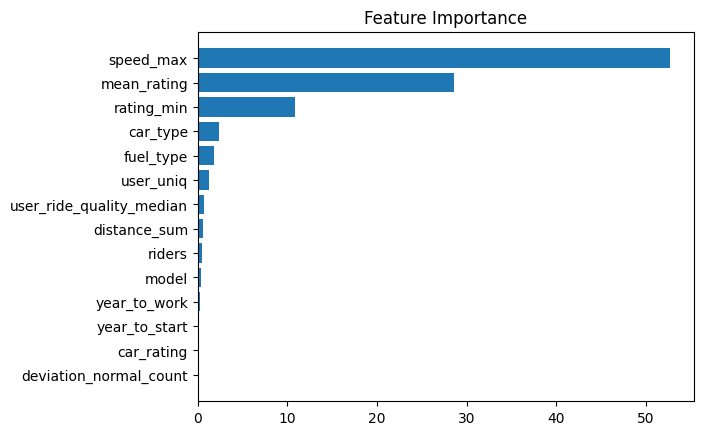

In [99]:
feature_importances = catboost_model.get_feature_importance()
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)

plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importance')
plt.show()

Модель сильнее всего опирается на speed_max, mean_rating и rating_min  именно они больше всего влияют на качество предсказания. Остальные признаки вносят меньший вклад.

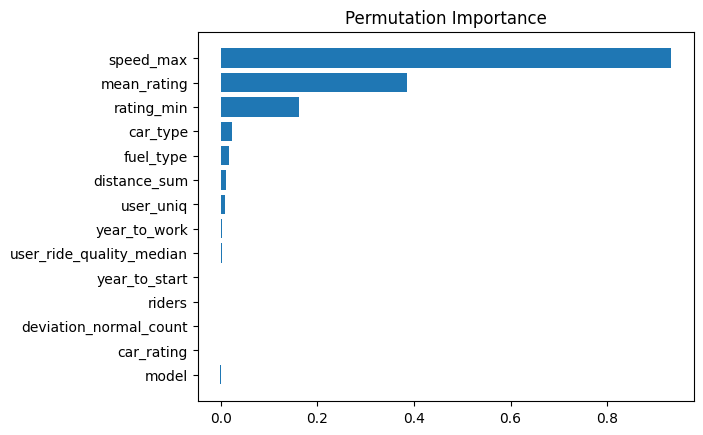

In [100]:
perm_importance = permutation_importance(catboost_model, X_valid, y_valid, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X_valid.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Permutation Importance')
plt.show()

Permutation Importance подтверждает, что ключевыми признаками остаются speed_max, mean_rating и rating_min. При их случайной перестановке ошибка модели резко растёт  значит, именно они наиболее критичны для точности предсказаний.

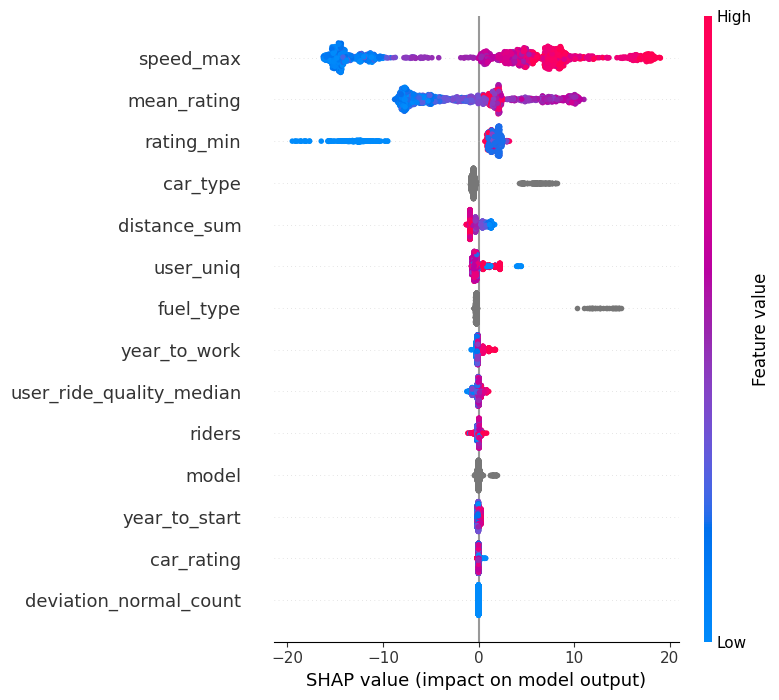

In [101]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
shap_values = catboost_model.get_feature_importance(data=train_pool, type='ShapValues')
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

- speed_max — самый сильный фактор: высокая скорость  увеличивает предсказание, низкая  снижает.
- car_type — определённые типы машин дают положительный вклад, другие — отрицательный.
- mean_rating — чем выше средняя оценка, тем лучше прогноз.
- rating_min — низкий минимальный рейтинг снижает результат.
- distance_sum — большие пробеги немного уменьшают прогноз.
- user_uniq — влияет слабо, лёгкий положительный эффект при росте.

Остальные признаки почти не влияют на предсказание модели.

In [102]:

cat_features = ['model', 'car_type', 'fuel_type']                             
cat_idx = [X_train.columns.get_loc(c) for c in cat_features]                   

cat_maps = {}                                                                  
for c in cat_features:
    cats = pd.Categorical(X_train[c]).categories.tolist()                     
    to_code  = {v: i for i, v in enumerate(cats)}                               
    to_label = {i: v for i, v in enumerate(cats)}                           
    fallback = X_train[c].mode(dropna=True).iloc[0] if not X_train[c].mode().empty else cats[0]
    cat_maps[c] = {"cats": cats, "to_code": to_code, "to_label": to_label, "fallback": fallback}

X_train_lime = X_train.copy()
X_valid_lime = X_valid.copy()
for c in cat_features:
    X_train_lime[c] = X_train[c].map(cat_maps[c]["to_code"]).astype(int)
    X_valid_lime[c] = X_valid[c].map(cat_maps[c]["to_code"])
    X_valid_lime[c] = X_valid_lime[c].fillna(
        cat_maps[c]["to_code"][cat_maps[c]["fallback"]]
    ).astype(int)

categorical_names = {X_train.columns.get_loc(c): cat_maps[c]["cats"] for c in cat_features}

def predict_for_lime_reg(X_arr: np.ndarray) -> np.ndarray:
    df_codes = pd.DataFrame(X_arr, columns=X_train.columns)               

    df = df_codes.copy()
    for c in cat_features:
        inv = cat_maps[c]["to_label"]                                   

        df[c] = df_codes[c].apply(lambda k: inv.get(int(round(k)), cat_maps[c]["fallback"])).astype(str)

    pool = Pool(data=df, cat_features=cat_features)                          
    y_hat = catboost_model.predict(pool)                               
    return np.asarray(y_hat).ravel()                                     

explainer_reg = lime_tabular.LimeTabularExplainer(
    training_data=X_train_lime.values,                                   
    feature_names=list(X_train.columns),                                
    mode='regression',                                          
    categorical_features=cat_idx,                                      
    categorical_names=categorical_names,                                
    discretize_continuous=True                                 
)

i = 0                                                              
x0_codes = X_valid_lime.iloc[i].values                                    

exp_reg = explainer_reg.explain_instance(
    data_row=x0_codes,                                               
    predict_fn=predict_for_lime_reg,                                     
    num_features=10                                                 
)

print('LIME (признак, вклад в предсказание):')
for feat, weight in exp_reg.as_list():
    print(f'  {feat:40s} {weight:+.4f}')

exp_reg.show_in_notebook(show_table=True)                     

LIME (признак, вклад в предсказание):
  speed_max > 188.28                       +12.6100
  fuel_type=electro                        +10.4588
  mean_rating <= 4.16                      -9.5032
  car_type=premium                         +7.3193
  rating_min <= 0.10                       -3.5575
  10518779.44 < distance_sum <= 13181285.33 +0.5940
  model=Volkswagen ID.4                    +0.4919
  riders > 86476.00                        +0.4371
  year_to_start > 2015.00                  +0.3473
  user_uniq <= 171.00                      +0.3338


Этот LIME-график показывает, какие признаки конкретно повлияли на предсказание для одного объекта:
- speed_max > 188.28 — главный положительный вклад, резко увеличил предсказание.
- mean_rating ≤ 4.16 и rating_min ≤ 0.10 - снижают результат, т.к. низкие рейтинги ассоциируются с худшим исходом.
- fuel_type = 0 немного улучшает прогноз, model = 25 — наоборот, снижает.
- Остальные признаки (пробег, год, riders) влияют слабо.

В целом высокая скорость компенсировала слабые рейтинги, поэтому итоговое предсказание получилось средним.

### Заключение



- Главный драйвер — speed_max: стабильно повышает прогноз. 
- Важные — mean_rating (+) и rating_min (–): качество рейтингов сильно влияет на результат.
- Средней силы — car_type, fuel_type.
- Остальные признаки — слабое влияние.


- SHAP и Permutation Importance совпадают.
- LIME подтверждает: высокая скорость компенсирует низкие рейтинги.


- 5-fold CV: RMSE = 11.66 ± 0.42, стабильная модель без переобучения.


### Теперь решим аналогично задачу классификации

In [103]:
train_path = '../data/raw/quickstart_train.csv'        
train = pd.read_csv(train_path)                         
print(train.shape)                                    
train.head()                                         

(2337, 17)


car_id              model  car_type fuel_type  car_rating  \
0  y13744087j     Kia Rio X-line   economy    petrol        3.78   
1  O41613818T         VW Polo VI   economy    petrol        3.90   
2  d-2109686j    Renault Sandero  standart    petrol        6.30   
3  u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4  N-8915870N    Renault Sandero  standart    petrol        4.70   

   year_to_start  riders  year_to_work  target_reg target_class  mean_rating  \
0           2015   76163          2021      109.99  another_bug     4.737759   
1           2015   78218          2021       34.48  electro_bug     4.480517   
2           2012   23340          2017       34.93   gear_stick     4.768391   
3           2011    1263          2020       32.22  engine_fuel     3.880920   
4           2012   26428          2017       27.51  engine_fuel     4.181149   

   distance_sum  rating_min   speed_max  user_ride_quality_median  \
0  1.214131e+07         0.1  180.855726                  0.023174   
1  1.803909e+07         0.0  187.862734                 12.306011   
2  1.588366e+07         0.1  102.382857                  2.513319   
3  1.651883e+07         0.1  172.793237                 -5.029476   
4  1.398317e+07         0.1  203.462289                -14.260456   

   deviation_normal_count  user_uniq  
0                     174        170  
1                     174        174  
2                     174        173  
3                     174        170  
4                     174        171

In [104]:

X = train.drop(['car_id', 'target_reg', 'target_class'], axis=1)  
y = train['target_class']                                         

cat_features = ['model', 'car_type', 'fuel_type']      

X_train_raw = X.copy()                                
# for feature in cat_features:                           
#     le = LabelEncoder()                                
#     X_train_raw[feature] = le.fit_transform(            
#         X_train_raw[feature].astype(str)                
#     )

X_train, X_valid, y_train, y_valid = train_test_split(  
    X_train_raw, y, test_size=0.2, random_state=42,     
    stratify=y                                          
)

In [ ]:
def val_metric(model, X_val, y_val):                 
        y_pred = model.predict(X_val)                   
        return f1_score(y_val, y_pred, average='macro') 

def objective(trial):                                                    
    boosting_type = trial.suggest_categorical('boosting_type',           
                                              ['Ordered', 'Plain'])      

  
    if boosting_type == 'Ordered':                                       
        bootstrap_type = 'No'                                           
        grow_policy = 'SymmetricTree'                                  
    else:                                                                
        bootstrap_type = trial.suggest_categorical('bootstrap_type',     
                                                   ['Bayesian', 'Bernoulli', 'MVS'])
        grow_policy = trial.suggest_categorical('grow_policy',           
                                                ['SymmetricTree', 'Depthwise', 'Lossguide'])

    subsample = (trial.suggest_float('subsample', 0.1, 1.0)              
                if bootstrap_type == 'Bernoulli' else None)


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),  
        'depth': trial.suggest_int('depth', 4, 10),                   
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),     
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'rsm': trial.suggest_float('rsm', 0.1, 1.0),                
        'border_count': trial.suggest_int('border_count', 1, 255),   
        'leaf_estimation_method': trial.suggest_categorical(            
            'leaf_estimation_method', ['Newton', 'Gradient']
        ),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'boosting_type': boosting_type,                                
        'bootstrap_type': bootstrap_type,                             
        'grow_policy': grow_policy,                                      
        'use_best_model': True,                                         
        'random_state': 42,                                    
        'loss_function': 'MultiClass',    
        'eval_metric': 'TotalF1'               
    }

    if bootstrap_type == 'Bayesian':                                   
        params['bagging_temperature'] = trial.suggest_float(
            'bagging_temperature', 1e-2, 100, log=True
        )
    if subsample is not None:                                        
        params['subsample'] = subsample


    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)  
    valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features) 


    model = CatBoostClassifier(**params)                               
    model.fit(train_pool, eval_set=valid_pool,                           
              early_stopping_rounds=50, verbose=False)

    score = val_metric(model, X_valid, y_valid)                        
    return score                                                      

study = optuna.create_study(direction='maximize',                     
                            sampler=TPESampler(seed=42),                 
                            pruner=MedianPruner())                    
study.optimize(objective, n_trials=100, show_progress_bar=True)        

print('Best trial score:', study.best_value)                  
print('Best params:', study.best_params)                                

best_params = study.best_params.copy()                                

best_params.update({                                                     
    'iterations': 3000,                                          
    'use_best_model': True,                                          
    'random_state': 42,                                                
    'loss_function': 'MultiClass',          
    'eval_metric':  'TotalF1'                  
})



  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
best_model = CatBoostClassifier(**best_params)                       
best_model.fit(                                                  
    Pool(X_train, y_train, cat_features=cat_features),
    eval_set=Pool(X_valid, y_valid, cat_features=cat_features),
    early_stopping_rounds=50,
    verbose=False
)
best_params['iterations'] = best_model.best_iteration_                   

final_model = CatBoostClassifier(**best_params)                          



In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)        
cv_scores = []                                                         

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_raw, y), 1):  
    X_tr, X_va = X_train_raw.iloc[tr_idx], X_train_raw.iloc[va_idx]     
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]                         

    final_model.fit(                                               
        Pool(X_tr, y_tr, cat_features=cat_features),
        eval_set=Pool(X_va, y_va, cat_features=cat_features),
        early_stopping_rounds=50,
        verbose=False
    )

    score = val_metric(final_model, X_va, y_va)                       
    cv_scores.append(score)                                     
    print(f'Fold {fold}: score = {score:.4f}')                      

print(f'Mean CV score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}') 

Fold 1: score = 0.8035
Fold 2: score = 0.7893
Fold 3: score = 0.7858
Fold 4: score = 0.8215
Fold 5: score = 0.8008
Mean CV score: 0.8002 ± 0.0126


In [ ]:
final_model.fit(
    Pool(X_train_raw, y, cat_features=cat_features),    
    eval_set=Pool(X_valid, y_valid, cat_features=cat_features),  
    early_stopping_rounds=50,
    verbose=False
)

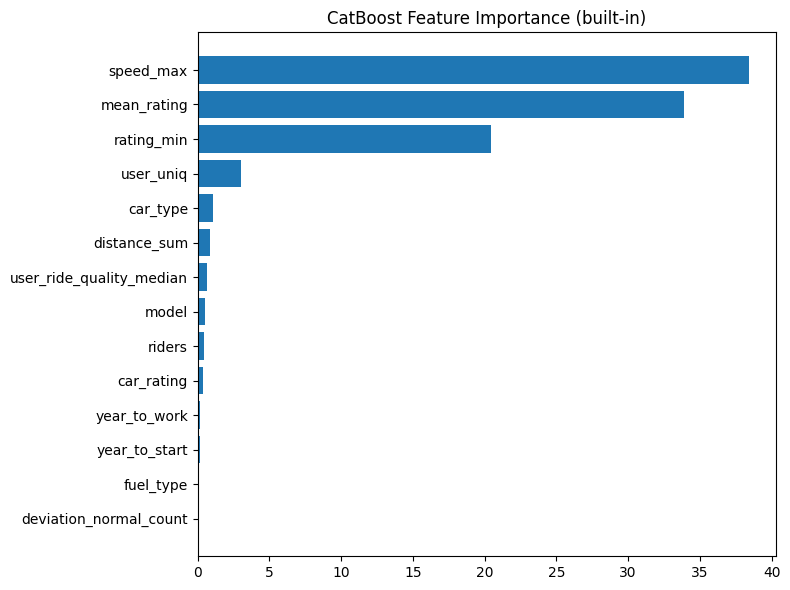

In [ ]:
fi = final_model.get_feature_importance()                               
order = np.argsort(fi)                                                 
plt.figure(figsize=(8, 6))                             
plt.barh(X_train_raw.columns[order], fi[order])                       
plt.title('CatBoost Feature Importance (built-in)')             
plt.tight_layout()                                                       
plt.show()                                                 



Главные предикторы — speed_max, mean_rating и rating_min: именно они определяют решение модели.
Рост максимальной скорости и среднего рейтинга повышает вероятность целевого класса,
а низкий минимальный рейтинг — наоборот, снижает.
Остальные признаки (тип авто, модель, пользовательская активность) дают слабый вклад.

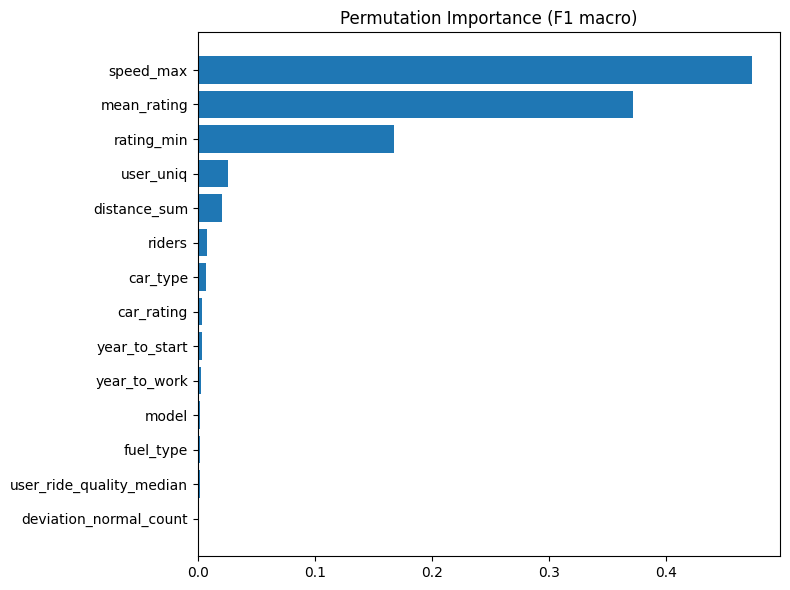

In [ ]:
from sklearn.inspection import permutation_importance

scoring = 'f1_macro'

perm = permutation_importance(final_model, X_valid, y_valid,
                              n_repeats=10, random_state=42, scoring=scoring)
order = perm.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(X_valid.columns[order], perm.importances_mean[order])
plt.title('Permutation Importance (F1 macro)')
plt.tight_layout()
plt.show()

При перестановке значений сильнее всего падает метрика при изменении speed_max, mean_rating и rating_min — значит, именно они критичны для точности классификации.
user_uniq и car_type оказывают умеренное влияние,
остальные признаки почти не влияют на предсказание модели.

(1869, 14) (1869, 14)


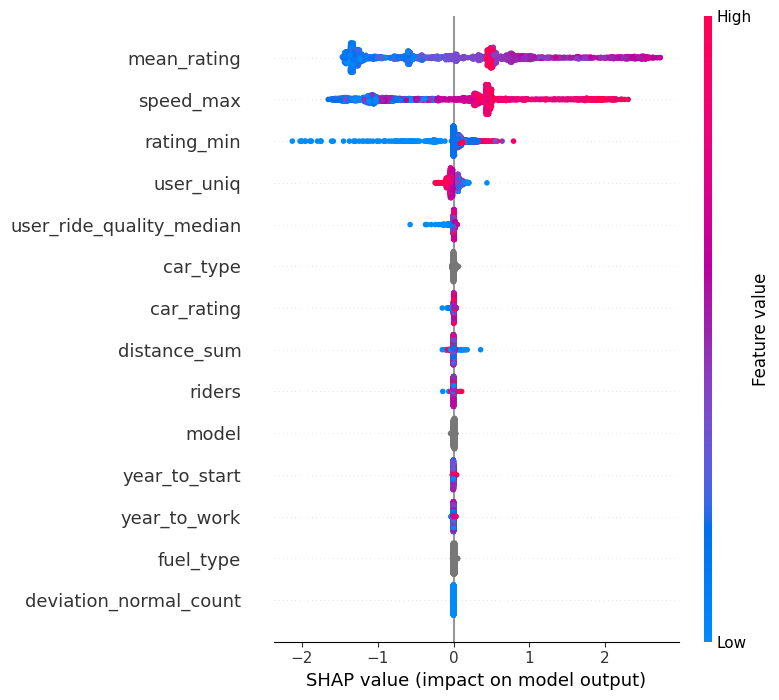

In [ ]:

train_pool = Pool(X_train, y_train, cat_features=cat_features)

shap_values = final_model.get_feature_importance(data=train_pool, type='ShapValues')

classes = list(pd.Categorical(y_train).categories)  
class_to_show_idx = 0                               


base_value = shap_values[0, class_to_show_idx, -1]   
shap_mat   = shap_values[:, class_to_show_idx, :-1] 

print(shap_mat.shape, X_train.shape) 

shap.summary_plot(shap_mat, X_train, feature_names=X_train.columns,
                  class_names=classes) 

Высокие значения mean_rating и speed_max  увеличивают вероятность целевого класса,
низкие  снижают.
Низкие rating_min также тянут предсказание вниз.
Остальные признаки дают слабый вклад и почти не влияют на решение модели.

In [ ]:
cat_features = ['model', 'car_type', 'fuel_type']                 
cat_idx = [X_train.columns.get_loc(c) for c in cat_features]      

cat_levels = {}
to_code = {}
to_str  = {}

X_train_lime = X_train.copy()
X_valid_lime = X_valid.copy()

for c in cat_features:
    cats = pd.Categorical(X_train[c].astype(str))
    cat_levels[c] = list(cats.categories)
    to_code[c] = {v: i for i, v in enumerate(cat_levels[c])}
    to_str[c]  = {i: v for i, v in enumerate(cat_levels[c])}

    X_train_lime[c] = X_train[c].astype(str).map(to_code[c]).fillna(-1).astype(int)
    X_valid_lime[c] = X_valid[c].astype(str).map(to_code[c]).fillna(-1).astype(int)

categorical_names = {X_train.columns.get_loc(c): cat_levels[c] for c in cat_features}

def predict_proba_for_lime(X_arr: np.ndarray) -> np.ndarray:
    df = pd.DataFrame(X_arr, columns=X_train.columns)          
    for c in cat_features:
        df[c] = df[c].round().astype(int).map(to_str[c]).fillna('UNK')
    pool = Pool(df, cat_features=cat_features)                 
    return np.asarray(final_model.predict_proba(pool))     

class_names = [str(c) for c in final_model.classes_]
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_lime.values,                
    feature_names=list(X_train.columns),
    class_names=class_names,
    mode='classification',
    categorical_features=cat_idx,                       
    categorical_names=categorical_names,                 
    discretize_continuous=True
)

i = 0
row_lime = X_valid_lime.iloc[i].values               
proba = predict_proba_for_lime(X_valid_lime.iloc[[i]].values)[0]
label_idx = int(np.argmax(proba))

exp = explainer.explain_instance(
    data_row=row_lime,
    predict_fn=predict_proba_for_lime,
    num_features=10,
    labels=[label_idx]
)

print('Sample index:', i)
print('Explained class index:', label_idx)
print('Explained class name :', class_names[label_idx])
print('LIME local explanation (feature, contribution):')
print(exp.as_list(label=label_idx))
exp.show_in_notebook()

Sample index: 0
Explained class index: 0
Explained class name : another_bug
LIME local explanation (feature, contribution):
[('mean_rating > 4.68', 0.3031498066480124), ('speed_max > 188.64', 0.2456612826408717), ('rating_min <= 0.10', -0.0634813016795593), ('car_rating > 4.98', 0.020474315742292352), ('user_ride_quality_median > 5.37', 0.015399139699124886), ('year_to_start <= 2013.00', -0.01331425667670355), ('car_type=economy', 0.011291479415067373), ('model=Kia Rio', 0.010114526378858044), ('user_uniq <= 171.00', 0.0040157017544500545), ('riders <= 41388.00', 0.003734717246374778)]


класс: another_bug, объект 0
Что тянет вероятность вверх:
- mean_rating > 4.68: +0.134 — высокий средний рейтинг повышает шанс класса.
- speed_max > 188.64: +0.125 — высокая максимальная скорость тоже усиливает предсказание.
- fuel_type=1: +0.019 — этот тип топлива слабо, но в плюс.
- Небольшие плюсы: user_ride_quality_median > 5.37, car_rating > 4.98, distance_sum в [13.2M; 16.3M], user_uniq ≤ 171, year_to_work ∈ (2018; 2020], riders ≤ 41 388 — вклад маленький, второстепенно.

Что тянет вниз :

- rating_min ≤ 0.10: −0.021 — очень низкая минимальная оценка снижает вероятность.

- Итог: решение в основном делают mean_rating и speed_max — их положительный вклад «перебивает» небольшой негатив от rating_min. Остальные признаки дают лишь косметические корректировки.

Заключение
- Главный драйвер — speed_max: рост значения повышает вероятность целевого класса.
- Важные — mean_rating (+) и rating_min (–): высокий средний рейтинг усиливает прогноз, низкий минимум снижает.
- Средней силы — car_type, fuel_type.
- SHAP и Permutation Importance показывают одинаковую структуру важностей.
- LIME подтверждает: высокая скорость компенсирует эффект низких рейтингов.
- 5-fold CV: модель стабильна F1 macro 0.8002 ± 0.0126